In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat
from numpy.linalg import lstsq
from scipy.stats import t

## Project Work 3

## Load previous data necessary for this assignment

In [2]:
def create_design_matrix(labels):
    """
    Creates a design matrix from a labels DataFrame.

    Parameters:
        labels (pandas.DataFrame): A DataFrame containing 'Condition' and 'Run' columns.

    Returns:
        pandas.DataFrame: The design matrix with conditions as columns.
    """
    # Get unique conditions from labels
    unique_conditions = labels["Condition"].unique()

    # Initialize the design matrix
    design_matrix = pd.DataFrame(0, index=np.arange(len(labels)), columns=unique_conditions)

    # Fill the design matrix
    for condition in unique_conditions:
        design_matrix[condition] = (labels["Condition"] == condition).astype(int)

    # Drop the 'rest' condition
    if "rest" in design_matrix.columns:
        design_matrix = design_matrix.drop(columns=["rest"])
        #print("'rest' condition dropped from the design matrix.")

    return design_matrix

In [3]:
def add_run_intercepts(design_matrix, labels): 
    """
    Adds intercept columns for each run to the design matrix.

    Parameters:
        design_matrix (pd.DataFrame): Original design matrix (time points × conditions).
        labels (pd.DataFrame): DataFrame with 'Condition' and 'Run' columns.

    Returns:
        pd.DataFrame: Design matrix with added intercept columns.
    """
    design_matrix_with_intercepts = design_matrix.copy()
    unique_runs = labels["Run"].unique()

    # Add intercept columns
    for run in unique_runs:
        run_column_name = f"Run_{run}"
        design_matrix_with_intercepts[run_column_name] = (labels["Run"] == run).astype(int)

    return design_matrix_with_intercepts

In [4]:
def convolve_conditions(design_matrix, hrf_sampled):
    """
    Convolves only the condition columns of the design matrix with the HRF.

    Parameters:
        design_matrix (pd.DataFrame): Design matrix with conditions and intercepts.
        hrf_sampled (numpy.ndarray): The sampled HRF.

    Returns:
        pd.DataFrame: Design matrix with convolved conditions and unmodified intercepts.
    """
    # Identify condition columns (non-intercept)
    condition_columns = [col for col in design_matrix.columns if not col.startswith("Run")]
    intercept_columns = [col for col in design_matrix.columns if col.startswith("Run")]

    # Initialize the convolved matrix
    convolved_matrix = pd.DataFrame(index=design_matrix.index)

    # Convolve conditions
    for condition in condition_columns:
        convolved_signal = np.convolve(design_matrix[condition], hrf_sampled, mode="full")[:len(design_matrix)]
        convolved_matrix[condition] = convolved_signal

    # Add intercept columns without modification
    for intercept in intercept_columns:
        convolved_matrix[intercept] = design_matrix[intercept]

    return convolved_matrix

In [5]:
def fit_glm_and_generate_beta_maps(bold_data, X):
    """
    Fits a General Linear Model (GLM) voxel-by-voxel and generates beta coefficient maps.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD fMRI data with shape (X, Y, Z, Time).
        X (pandas.DataFrame): The convolved design matrix.

    Returns:
        numpy.ndarray: Beta coefficient maps with shape (X, Y, Z, N_conditions).
    """
    # Reshape the fMRI data for voxel-wise analysis
    Y = bold_data.reshape(-1, bold_data.shape[-1]).T  # Shape: (Time, Voxels)
    #print(f"fMRI data reshaped to: {Y.shape}")

    # Ensure the design matrix is aligned with the fMRI data
    assert Y.shape[0] == X.shape[0], "Mismatch in time points!"

    # Solve the GLM
    X_pinv = np.linalg.pinv(X)  # Use pseudo-inverse for stability
    beta_matrix = X_pinv @ Y

    
    # Compute residuals (optional, for model evaluation)
    residuals = Y - (X @ beta_matrix)  # Shape: (Time, N_voxels)

    # Reshape beta coefficients back to brain space
    beta_maps = beta_matrix.T.reshape(bold_data.shape[:-1] + (X.shape[1],))  # Shape: (X, Y, Z, N_conditions)

    return residuals, beta_maps

In [6]:
# Load the NIfTI file
bold_path = "subj1/bold.nii.gz"
bold_img = nib.load(bold_path)

# Extract the data as a NumPy array
bold_data = bold_img.get_fdata()

# Load the labels into a pandas DataFrame
labels = pd.read_csv("subj1/labels.txt", sep=" ", header=0, names=["Condition", "Run"])

# Get unique conditions from labels
unique_conditions = [condition for condition in labels["Condition"].unique() if condition != "rest"]

# Create the design matrix
design_matrix = create_design_matrix(labels)

# Modify the convolved matrix
design_matrix_with_intercepts  = add_run_intercepts(design_matrix, labels)

# Load the HRF file
hrf_path = "hrf.mat"  
hrf_data = loadmat(hrf_path)
hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Downsampled HRF

convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)

# load design matrix as "convolved_matrix"
X = convolved_matrix.values
df = X.shape[0] - np.linalg.matrix_rank(X)

# Fit the GLM and get results
residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, X)

In [7]:
# Load ROI masks
vt_mask_path = "subj1/mask4_vt.nii.gz"
face_mask_path = "subj1/mask8_face_vt.nii.gz"
house_mask_path = "subj1/mask8_house_vt.nii.gz"

vt_mask = nib.load(vt_mask_path).get_fdata() > 0  # Ventral Temporal ROI
face_mask = nib.load(face_mask_path).get_fdata() > 0  # Face ROI
house_mask = nib.load(house_mask_path).get_fdata() > 0  # House ROI

# Generate random ROIs
brain_mask = vt_mask | face_mask | house_mask  # Approximation of the whole brain

# Random inside ROI: Within the brain
random_roi_inside = np.random.choice([False, True], size=vt_mask.shape, p=[0.995, 0.005]) & brain_mask

# Random outside ROI: Outside the brain
random_roi_outside = np.random.choice([False, True], size=vt_mask.shape, p=[0.999, 0.001]) & ~brain_mask

# Store masks in a dictionary for convenience
roi_masks = {
    "Ventral Temporal": vt_mask,
    "Face": face_mask,
    "House": house_mask,
    "Random Inside": random_roi_inside,
    "Random Outside": random_roi_outside,
}

In [8]:
# Base path for BOLD files (subject-specific)
base_bold_path = "subj{}/bold.nii.gz"

# Paths for labels and HRF (shared across subjects)
base_labels_path = "subj{}/labels.txt"
hrf_path = "hrf.mat"

base_vt_mask_path = "subj{}/mask4_vt.nii.gz"
base_face_mask_path = "subj{}/mask8_face_vt.nii.gz"
base_house_mask_path = "subj{}/mask8_house_vt.nii.gz"

In [9]:
def split_data_by_runs(labels, convolved_matrix, bold_data):
    """
    Splits the data into even and odd runs and ensures proper intercept handling.

    Parameters:
        labels (pd.DataFrame): DataFrame containing 'Condition' and 'Run'.
        convolved_matrix (pd.DataFrame): Full design matrix (time points × conditions + intercepts).
        bold_data (np.ndarray): BOLD fMRI data with shape (X, Y, Z, Time).

    Returns:
        dict: Dictionary with keys 'even' and 'odd', each containing:
              - "design_matrix": Split design matrix for even/odd runs (time points/2 × 14).
              - "bold_data": Corresponding split BOLD data.
    """
    # Get indices for even and odd runs
    even_indices = labels.index[labels["Run"] % 2 == 0]
    odd_indices = labels.index[labels["Run"] % 2 == 1]

    # Extract condition columns and appropriate intercepts for even runs
    even_conditions = [col for col in convolved_matrix.columns if not col.startswith("Run_")]
    even_intercepts = [f"Run_{run}" for run in labels["Run"].unique() if run % 2 == 0]
    even_columns = even_conditions + even_intercepts

    # Extract condition columns and appropriate intercepts for odd runs
    odd_conditions = [col for col in convolved_matrix.columns if not col.startswith("Run_")]
    odd_intercepts = [f"Run_{run}" for run in labels["Run"].unique() if run % 2 == 1]
    odd_columns = odd_conditions + odd_intercepts

    # Create split design matrices
    even_design_matrix = convolved_matrix.loc[even_indices, even_columns]
    odd_design_matrix = convolved_matrix.loc[odd_indices, odd_columns]

    # Split BOLD data
    even_bold_data = bold_data[..., even_indices]
    odd_bold_data = bold_data[..., odd_indices]

    # Return results
    return {
        "even": {
            "design_matrix": even_design_matrix,
            "bold_data": even_bold_data,
        },
        "odd": {
            "design_matrix": odd_design_matrix,
            "bold_data": odd_bold_data,
        },
    }

In [10]:
# Step 4: Split the data into even and odd runs
split_data = split_data_by_runs(labels, convolved_matrix, bold_data)

In [11]:
# Verify the shapes of the resulting matrices
#print("Even run design matrix shape:", split_data["even"]["design_matrix"].shape)
#print("Odd run design matrix shape:", split_data["odd"]["design_matrix"].shape)
#print("Even run BOLD data shape:", split_data["even"]["bold_data"].shape)
#print("Odd run BOLD data shape:", split_data["odd"]["bold_data"].shape)

In [12]:
#intercept_columns_even = [col for col in split_data["even"]["design_matrix"].columns if col.startswith("Run_")]
#even_interept_values = {col: split_data["even"]["design_matrix"][col].unique() for col in intercept_columns_even}
#odd_intercept_columns = [col for col in split_data["odd"]["design_matrix"].columns if col.startswith("Run_")]
#odd_intercept_values = {col: split_data["odd"]["design_matrix"][col].unique() for col in odd_intercept_columns}

In [13]:
def visualize_design_matrix(design_matrix, title):
    """
    Visualizes the design matrix with enhancements for better column clarity.
    
    Parameters:
        design_matrix (pd.DataFrame): The design matrix to visualize.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(14, 8))  # Increase figure size for clarity
    plt.imshow(design_matrix.values, aspect="auto", cmap="gray", interpolation="none")
    plt.colorbar(label="Regressor Value")
    
    # Add vertical gridlines to separate columns
    num_columns = design_matrix.shape[1]
    plt.xticks(ticks=range(num_columns), labels=design_matrix.columns, rotation=90)
    plt.grid(axis="x", color="white", linestyle="--", linewidth=0.5)
    
    plt.title(title)
    plt.xlabel("Regressors")
    plt.ylabel("Time Points")
    plt.tight_layout()
    plt.show()


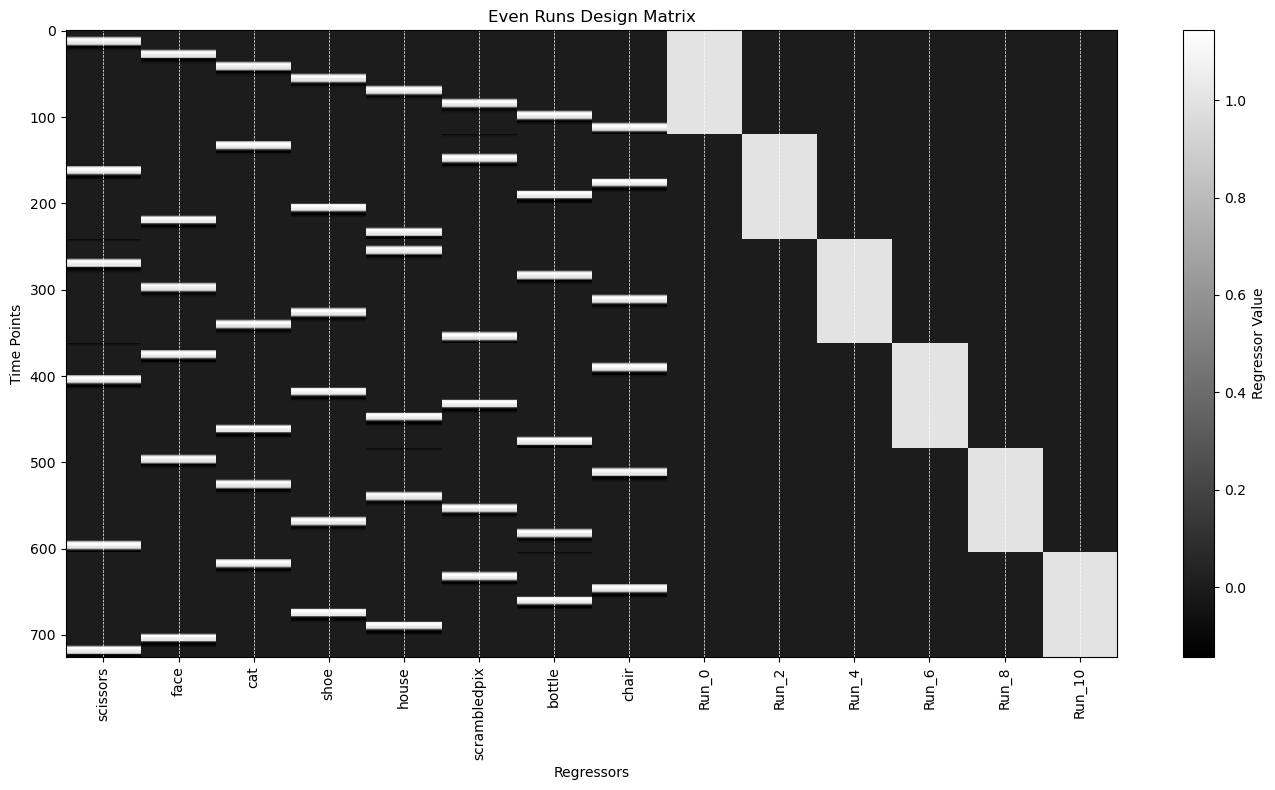

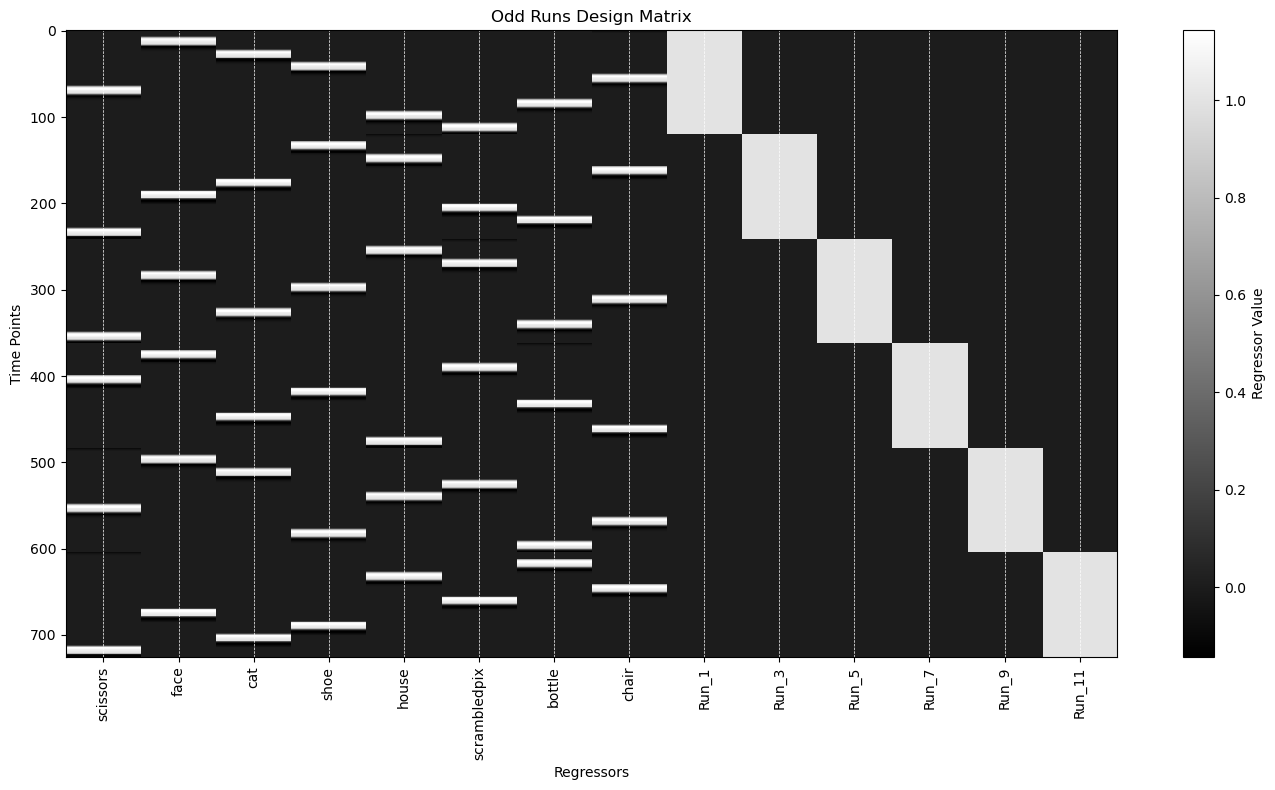

In [14]:
# Visualize the even and odd design matrices
visualize_design_matrix(split_data["even"]["design_matrix"], "Even Runs Design Matrix")
visualize_design_matrix(split_data["odd"]["design_matrix"], "Odd Runs Design Matrix")

In [15]:
def compute_t_values(beta_maps, design_matrix, residuals, df, mask=None, variance_threshold=1e-12, epsilon=1e-10):
    """
    Computes t-values for beta maps and residuals.

    Parameters
    ----------
    beta_maps : np.ndarray
        4D array of beta coefficients, shape (X, Y, Z, N_conditions).
    design_matrix : pd.DataFrame
        Design matrix, shape (time_points, N_conditions).
    residuals : np.ndarray
        Residuals, shape (time_points, N_voxels).
    df : int
        Degrees of freedom (time_points - rank(X)).
    mask : np.ndarray, optional
        Boolean array (X, Y, Z). Restricts computations if provided.
    variance_threshold : float, optional
        Minimum residual variance threshold.
    epsilon : float, optional
        Small value to avoid division by zero.

    Returns
    -------
    t_maps : np.ndarray
        4D array of t-values, shape (X, Y, Z, N_conditions).
    """
    X = design_matrix.values
    X_pinv = np.linalg.pinv(X)
    diag_cov = np.diag(X_pinv @ X_pinv.T).astype(float)

    # Handle zero values in diag_cov
    diag_cov = np.maximum(diag_cov, epsilon)
    # diag_cov = np.diag(np.linalg.pinv(design_matrix.values.T @ design_matrix.values))

    n_time_points, n_regressors = X.shape
    X_size, Y_size, Z_size, n_conditions = beta_maps.shape
    assert n_regressors == n_conditions, "Mismatch between design matrix and beta maps."

    beta_reshaped = beta_maps.reshape(-1, n_conditions)
    n_voxels = X_size * Y_size * Z_size
    assert residuals.shape == (n_time_points, n_voxels), "Residuals shape mismatch."

    if mask is not None:
        assert mask.shape == (X_size, Y_size, Z_size), "Invalid mask shape."
        mask_indices = np.where(mask.flatten())
        beta_reshaped = beta_reshaped[mask_indices]
        residuals = residuals[:, mask_indices[0]]
    else:
        mask_indices = None

    residual_var = np.sum(residuals**2, axis=0) / df
    residual_var = np.maximum(residual_var, variance_threshold)

    # Ensure residual_var is a NumPy array
    residual_var = np.asarray(residual_var)

    # Compute standard errors and enforce epsilon for safety
    SE = np.sqrt(residual_var[:, np.newaxis] * diag_cov)
    SE = np.maximum(SE, epsilon)

    # Compute t-values
    t_values = beta_reshaped / SE

    # Reconstruct t-maps
    t_maps = np.zeros((X_size, Y_size, Z_size, n_conditions), dtype=np.float32)
    if mask is not None:
        t_maps_flat = t_maps.reshape(-1, n_conditions)
        t_maps_flat[mask_indices] = t_values
        t_maps = t_maps_flat.reshape(X_size, Y_size, Z_size, n_conditions)
    else:
        t_maps = t_values.reshape(X_size, Y_size, Z_size, n_conditions)

    return t_maps

In [16]:
# Step 2: Fit GLMs and compute T-maps
def fit_glm_and_compute_tmaps(split_data, df):
    """
    Fits GLMs and computes T-maps for the given split data.

    Parameters:
        split_data (dict): Dictionary containing 'even' and 'odd' subsets.
        df (int): Degrees of freedom for GLM.

    Returns:
        dict: Dictionary with beta maps, residuals, and t-maps for even and odd runs.
    """
    results = {}
    for run_type in ["even", "odd"]:
        design_matrix = split_data[run_type]["design_matrix"]
        bold_data = split_data[run_type]["bold_data"]

        # Fit the GLM
        residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, design_matrix)

        # Compute T-maps
        t_maps = compute_t_values(
            beta_maps=beta_maps,
            design_matrix=design_matrix,
            residuals=residuals,
            df=df
        )

        results[run_type] = {
            "beta_maps": beta_maps,
            "residuals": residuals,
            "t_maps": t_maps,
        }

    return results

In [17]:
# Compute degrees of freedom and fit GLM
df = split_data["even"]["design_matrix"].shape[0] - np.linalg.matrix_rank(split_data["even"]["design_matrix"].values)
glm_results = fit_glm_and_compute_tmaps(split_data, df)

In [18]:
# Extract t-maps for a condition
def extract_condition_t_maps(glm_results, design_matrix, condition_name):
    """
    Extracts the t-maps corresponding to a specific condition.

    Parameters:
        glm_results (dict): Dictionary with t-maps for even and odd runs.
        design_matrix (pd.DataFrame): The original design matrix.
        condition_name (str): The condition of interest.

    Returns:
        dict: T-maps for the given condition (keys: 'even', 'odd').
    """
    if condition_name not in design_matrix.columns:
        raise ValueError(f"Condition '{condition_name}' not found in the design matrix.")
        
    condition_idx = list(design_matrix.columns).index(condition_name)
    
    return {
        run_type: glm_results[run_type]["t_maps"][..., condition_idx]
        for run_type in ["even", "odd"]
    }

In [19]:
# Apply ROI mask to t-maps
def apply_mask_to_t_maps(t_maps, mask):
    """
    Applies an ROI mask to the t-maps.
    """
    return t_maps[mask]

In [20]:
# Compute and verify within- and between-condition correlations
def compute_and_verify_correlations(glm_results, design_matrix, mask):
    """
    Computes within- and between-condition correlations for all conditions
    and checks if within-correlation is higher than all between-correlations.

    Parameters:
        glm_results (dict): GLM results with t-maps for even and odd runs.
        design_matrix (pd.DataFrame): Original design matrix.
        mask (np.ndarray): 3D boolean ROI mask.

    Returns:
        dict: Dictionary of within- and between-condition correlations for each condition,
              with verification results.
    """
    true_conditions = [col for col in design_matrix.columns if not col.startswith("Run")]

    results = {}
    for condition in true_conditions:
        t_maps_condition = extract_condition_t_maps(glm_results, design_matrix, condition)
        masked_even = apply_mask_to_t_maps(t_maps_condition["even"], mask)
        masked_odd = apply_mask_to_t_maps(t_maps_condition["odd"], mask)

        # Compute within-condition correlation
        within_correlation = np.corrcoef(masked_even.flatten(), masked_odd.flatten())[0, 1]

        # Compute between-condition correlations
        between_correlations = {
            other_condition: np.corrcoef(masked_even.flatten(),
                                         apply_mask_to_t_maps(
                                             extract_condition_t_maps(glm_results, design_matrix, other_condition)["odd"], mask).flatten()
                                         )[0, 1]
            for other_condition in true_conditions if other_condition != condition
        }

        is_higher = all(within_correlation > corr for corr in between_correlations.values())
        results[condition] = {
            "within": within_correlation,
            "between": between_correlations,
            "is_higher": is_higher,
        }

    return results

In [21]:
def plot_within_between_correlations(correlation_results):
    """
    Plots a separate bar chart for each condition in correlation_results.

    Parameters
    ----------
    correlation_results : dict
        Output from compute_and_verify_correlations, i.e.:
        {
          "face": {
            "within": float,
            "between": {"face vs. scissors": float, ...},
            "is_higher": bool
          },
          ...
        }
    """
    # Convert the dictionary format:
    # correlation_results[condition]["within"] -> float
    # correlation_results[condition]["between"] -> {other_condition: correlation, ...}
    # correlation_results[condition]["is_higher"] -> bool

    conditions = list(correlation_results.keys())
    n_conditions = len(conditions)

    # Create one subplot per condition
    fig, axes = plt.subplots(n_conditions, 1,
                             figsize=(8, 3 * n_conditions),
                             sharex=False)

    if n_conditions == 1:
        # If there's only one condition, make 'axes' a list for consistency
        axes = [axes]

    for i, condition in enumerate(conditions):
        ax = axes[i]
        corr_info = correlation_results[condition]

        # We'll plot 'Within' as one bar, and each "between" correlation as additional bars
        categories = ["Within"]
        corr_values = [corr_info["within"]]

        # Append the between-condition categories/values
        for other_cond, val in corr_info["between"].items():
            # The dictionary key is typically "face vs. scissors"
            # but you might prefer just "scissors" to keep the label short.
            if " vs. " in other_cond:
                # everything after ' vs. '
                short_label = other_cond.split(" vs. ")[-1]
            else:
                short_label = other_cond
            categories.append(short_label)
            corr_values.append(val)

        # Plot the bars
        x_positions = np.arange(len(categories))
        bars = ax.bar(x_positions, corr_values, color="skyblue")

        # Color the 'Within' bar specially if desired:
        if corr_info["is_higher"]:
            bars[0].set_color("tomato")  # e.g. red if it's higher than all between
        else:
            bars[0].set_color("gray")    # or gray if not

        # Labeling and cosmetics
        ax.set_title(f"Condition: {condition}")
        ax.set_ylabel("Correlation")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(categories, rotation=45, ha="right")
        ax.set_ylim([-1, 1])  # typical correlation range

        # Optional: annotate each bar with its numeric value
        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                np.sign(height) * (abs(height) + 0.02),  # a little above/below the bar
                f"{height:.2f}",
                ha="center",
                va="bottom" if height >= 0 else "top",
                color="black"
            )

    plt.tight_layout()
    plt.show()

In [22]:
# Run correlation computations 
correlation_results = compute_and_verify_correlations(glm_results, convolved_matrix, vt_mask)

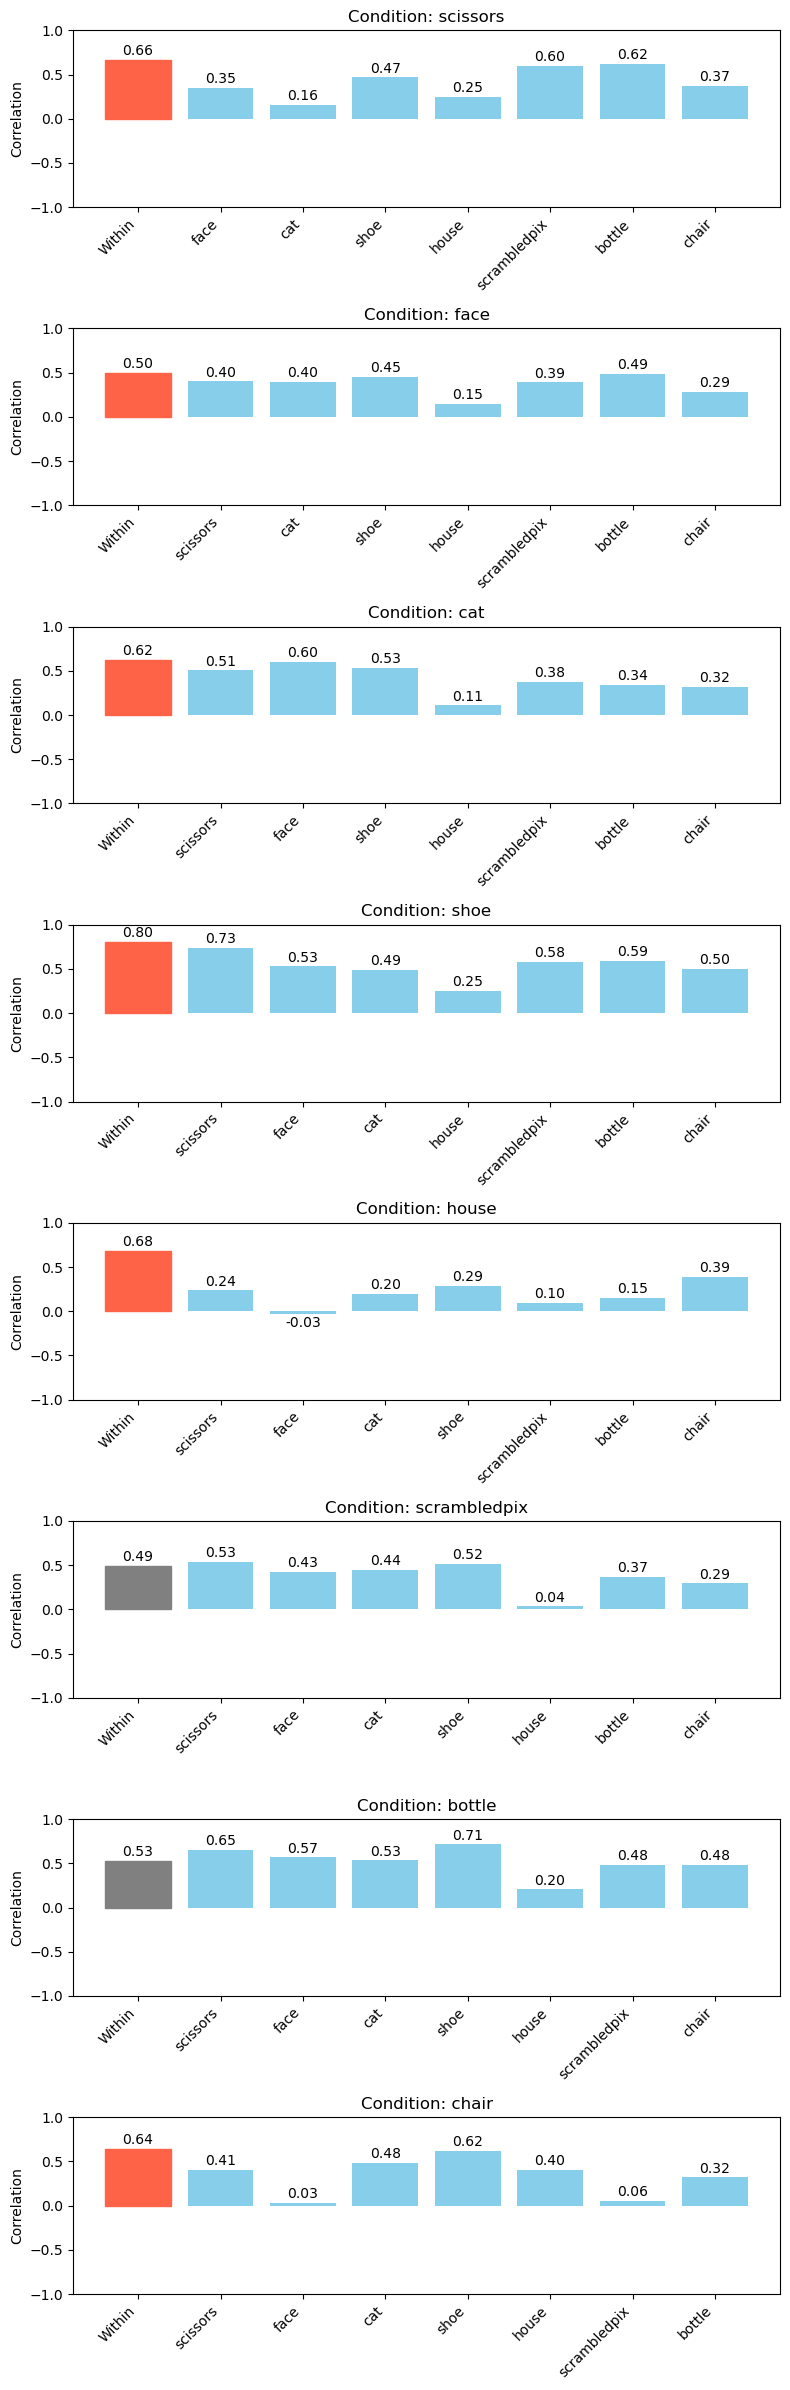

In [23]:
plot_within_between_correlations(correlation_results)

In [24]:
def load_subject_data(bold_path, labels_path):
    """
    Load fMRI BOLD data and labels for a subject.

    Parameters:
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).

    Returns:
        bold_data (numpy.ndarray): 4D BOLD data array.
        labels (pandas.DataFrame): Labels DataFrame with 'Condition' and 'Run'.
    """
    # Load the fMRI BOLD data
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()

    # Load the labels
    labels = pd.read_csv(labels_path, sep=" ", header=0, names=["Condition", "Run"])

    return bold_data, labels

In [25]:
def compute_group_correlations(subject_ids, base_bold_path, base_labels_path, hrf_path, base_vt_mask_path, unique_conditions):
    """
    Compute within- and between-condition correlations for all subjects and average the results.

    Parameters:
        subject_ids (list): List of subject IDs.
        base_bold_path (str): Template path for subject-specific BOLD files.
        base_labels_path (str): Template path for subject-specific labels files.
        hrf_path (str): Path to the HRF file.
        base_vt_mask_path (str): Template path for subject-specific Ventral Temporal ROI masks.
        unique_conditions (list): List of unique conditions.

    Returns:
        dict: Group-level correlation results with mean and SEM for within and between conditions.
    """
    all_subject_results = {cond: {"within": [], "between": {}} for cond in unique_conditions}

    # Perform group-level analysis
    for subj_id in subject_ids:
        print(f"Processing subject {subj_id}...")
        
        # Generate paths for subject-specific data
        bold_path = base_bold_path.format(subj_id)
        labels_path = base_labels_path.format(subj_id)
        vt_mask_path = base_vt_mask_path.format(subj_id)  # Subject-specific VT mask path

        # Load subject-specific VT mask
        vt_mask = nib.load(vt_mask_path).get_fdata() > 0

        # Perform subject-level analysis
        bold_data, labels = load_subject_data(bold_path, labels_path)
        design_matrix = create_design_matrix(labels)
        design_matrix_with_intercepts = add_run_intercepts(design_matrix, labels)
        hrf_data = loadmat(hrf_path)["hrf_sampled"].flatten()
        convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_data)
    
        # Split data into even and odd runs and fit GLMs
        split_data = split_data_by_runs(labels, convolved_matrix, bold_data)
        df = split_data["even"]["design_matrix"].shape[0] - np.linalg.matrix_rank(split_data["even"]["design_matrix"].values)
        glm_results = fit_glm_and_compute_tmaps(split_data, df)
    
        # Compute correlations for this subject using the subject-specific VT mask
        subj_correlations = compute_and_verify_correlations(glm_results, convolved_matrix, vt_mask)
        
        # Aggregate correlations for group-level analysis
        for condition, results in subj_correlations.items():
            all_subject_results[condition]["within"].append(results["within"])
            for other_condition, corr in results["between"].items():
                if other_condition not in all_subject_results[condition]["between"]:
                    all_subject_results[condition]["between"][other_condition] = []
                all_subject_results[condition]["between"][other_condition].append(corr)

    # Compute group-level means and SEMs
    group_results = {}
    for condition, data in all_subject_results.items():
        group_results[condition] = {
            "within": {
                "mean": np.mean(data["within"]),
                "sem": np.std(data["within"]) / np.sqrt(len(data["within"]))
            },
            "between": {
                other_cond: {
                    "mean": np.mean(corrs),
                    "sem": np.std(corrs) / np.sqrt(len(corrs))
                }
                for other_cond, corrs in data["between"].items()
            }
        }

    return group_results

In [26]:
def plot_group_correlations(group_correlation_results):
    """
    Plot group-level within- and between-condition correlations.

    Parameters:
        group_correlation_results (dict): Group-level correlation results with mean and SEM.
    """
    conditions = list(group_correlation_results.keys())
    n_conditions = len(conditions)

    # Create one subplot per condition
    fig, axes = plt.subplots(n_conditions, 1, figsize=(8, 3 * n_conditions), sharex=False)

    if n_conditions == 1:
        axes = [axes]

    for i, condition in enumerate(conditions):
        ax = axes[i]
        group_data = group_correlation_results[condition]

        categories = ["Within"]
        mean_values = [group_data["within"]["mean"]]
        sem_values = [group_data["within"]["sem"]]

        for other_cond, stats in group_data["between"].items():
            categories.append(other_cond)
            mean_values.append(stats["mean"])
            sem_values.append(stats["sem"])

        x_positions = np.arange(len(categories))
        bars = ax.bar(x_positions, mean_values, yerr=sem_values, color="skyblue", alpha=0.7, capsize=5)

        # Highlight 'Within' bar
        bars[0].set_color("tomato")

        ax.set_title(f"Condition: {condition}", fontsize=12)
        ax.set_ylabel("Correlation", fontsize=10)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(categories, rotation=45, ha="right")
        ax.set_ylim([-1, 1])

        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02, f"{height:.2f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()


In [27]:
subject_ids = ["1", "2", "3", "4", "5", "6"]

Processing subject 1...
Processing subject 2...
Processing subject 3...
Processing subject 4...
Processing subject 5...
Processing subject 6...


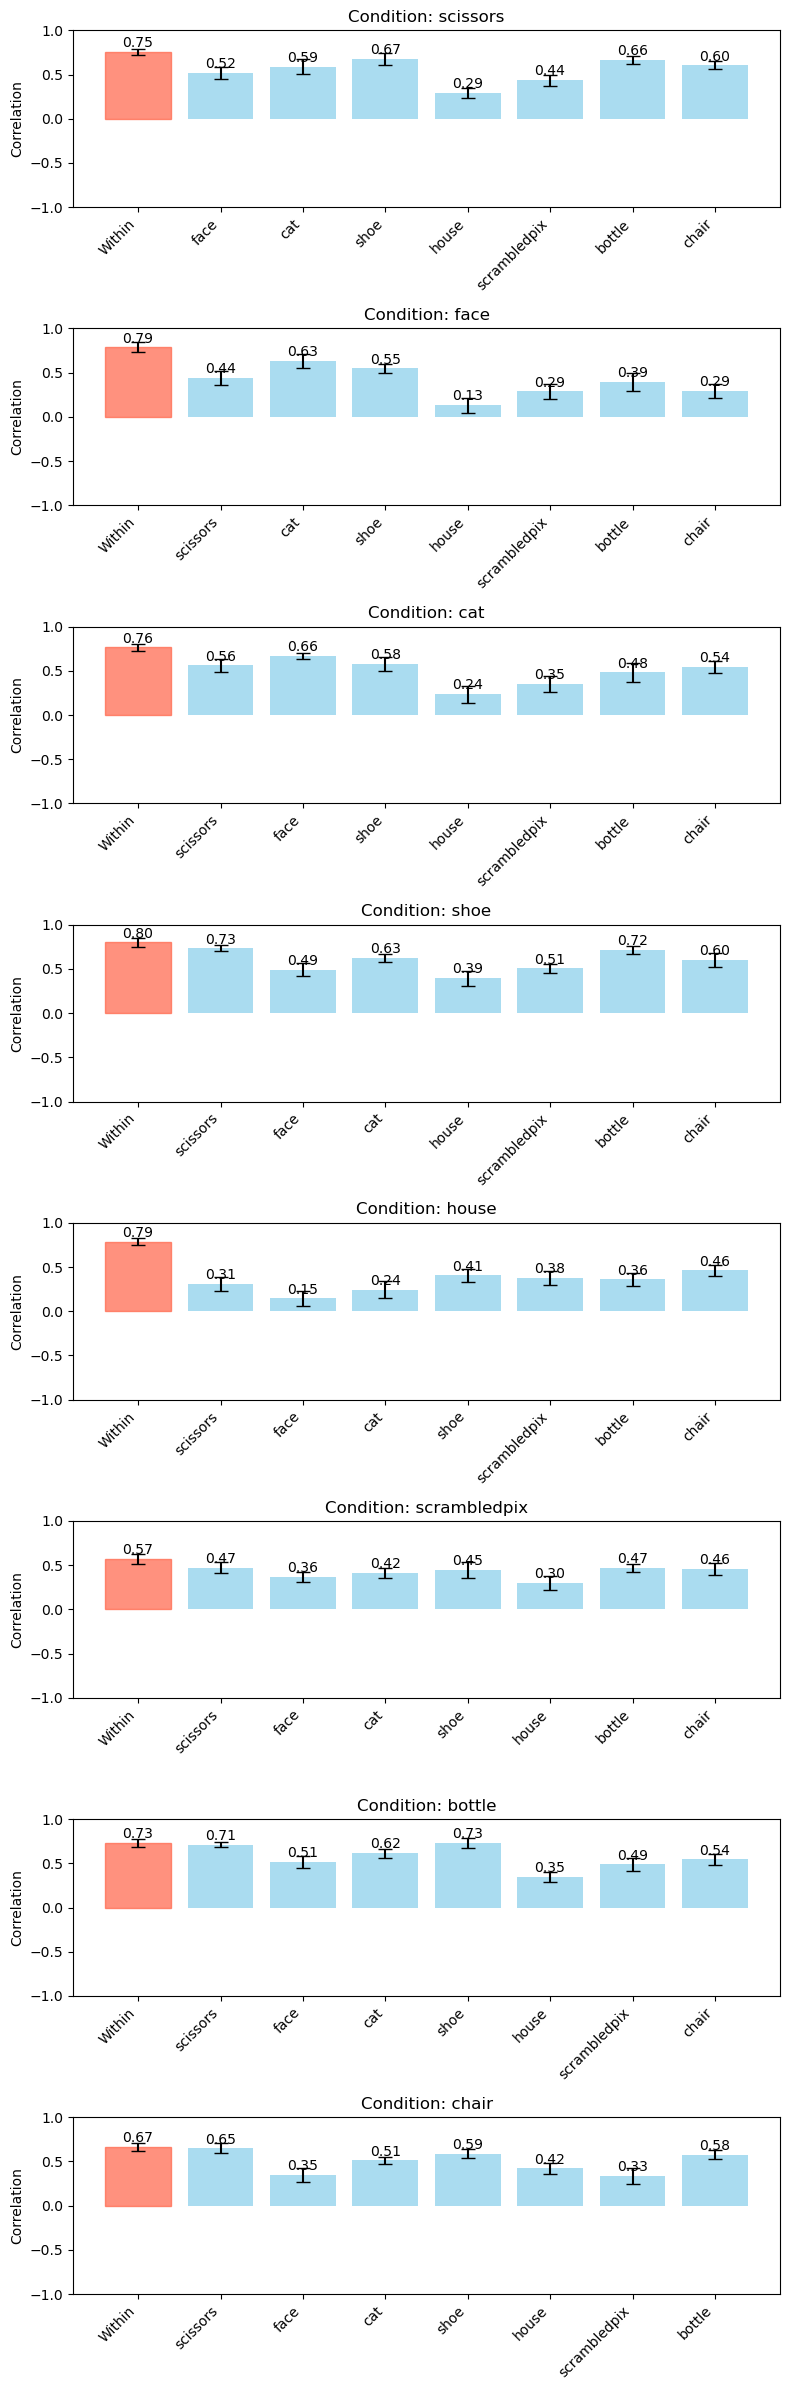

In [28]:
group_correlation_results = compute_group_correlations(
    subject_ids,
    base_bold_path,
    base_labels_path,
    hrf_path,
    base_vt_mask_path,
    unique_conditions
)

plot_group_correlations(group_correlation_results)